In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools
import os
import shutil
import random
import glob
import time
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1120)])
  except RuntimeError as e:
    print(e)

In [3]:
train_path = 'dataset/train'
valid_path = 'dataset/valid'
test_path = 'dataset/test'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)
#preprcoess_function scales input pixels between -1 and 1

Found 10101 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.
Found 2313 images belonging to 6 classes.


In [5]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [6]:
%%time
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [7]:
x = mobile.layers[-1].output

In [8]:
output = Dense(units=6, activation='softmax')(x)

In [9]:
from tensorflow.keras.models import Model

In [10]:
model = Model(inputs=mobile.input, outputs=output)

In [11]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [12]:
model.compile(
      optimizer=Adam(learning_rate=0.0001)
    , loss='categorical_crossentropy'
    , metrics=['accuracy']
)

In [13]:
%%time
history = model.fit(
      x=train_batches
    , steps_per_epoch=len(train_batches)
    , validation_data=valid_batches
    , validation_steps=len(valid_batches)
    , epochs=50
    , verbose=2
)

Epoch 1/50
1011/1011 - 70s - loss: 1.6988 - accuracy: 0.7202 - val_loss: 1.6264 - val_accuracy: 0.8700 - 70s/epoch - 69ms/step
Epoch 2/50
1011/1011 - 72s - loss: 1.5442 - accuracy: 0.9289 - val_loss: 1.4961 - val_accuracy: 0.9325 - 72s/epoch - 71ms/step
Epoch 3/50
1011/1011 - 80s - loss: 1.4165 - accuracy: 0.9567 - val_loss: 1.3779 - val_accuracy: 0.9483 - 80s/epoch - 79ms/step
Epoch 4/50
1011/1011 - 104s - loss: 1.2982 - accuracy: 0.9691 - val_loss: 1.2688 - val_accuracy: 0.9592 - 104s/epoch - 103ms/step
Epoch 5/50
1011/1011 - 135s - loss: 1.1873 - accuracy: 0.9760 - val_loss: 1.1648 - val_accuracy: 0.9650 - 135s/epoch - 133ms/step
Epoch 6/50
1011/1011 - 98s - loss: 1.0823 - accuracy: 0.9816 - val_loss: 1.0661 - val_accuracy: 0.9683 - 98s/epoch - 97ms/step
Epoch 7/50
1011/1011 - 339s - loss: 0.9831 - accuracy: 0.9851 - val_loss: 0.9722 - val_accuracy: 0.9708 - 339s/epoch - 335ms/step
Epoch 8/50
1011/1011 - 350s - loss: 0.8900 - accuracy: 0.9885 - val_loss: 0.8869 - val_accuracy: 0.970

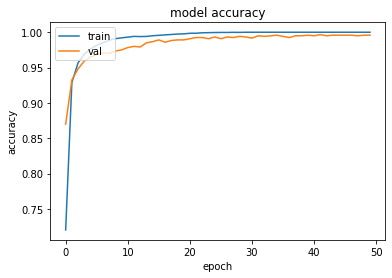

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('acc_05_50.png')
plt.show()

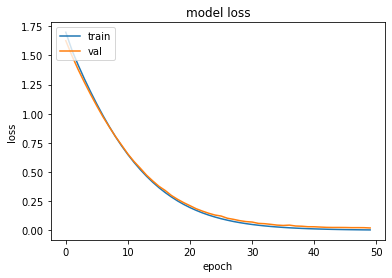

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_05_50.png')
plt.show()

In [16]:
test_labels = test_batches.classes

In [17]:
test_batches.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [18]:
%%time
predictions = model.predict(x=test_batches, verbose=0)

CPU times: total: 20.6 s
Wall time: 22.1 s


In [19]:
print(predictions.shape)

(2313, 6)


In [20]:
%%time
model.evaluate(test_batches)

232/232 [==============================] - 13s 56ms/step - loss: 0.0122 - accuracy: 0.9978
CPU times: total: 33.5 s
Wall time: 13.2 s


[0.012189043685793877, 0.9978383183479309]

In [21]:
%%time
loss, accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

232/232 [==============================] - 13s 56ms/step - loss: 0.0122 - accuracy: 0.9978
Test accuracy : 0.9978383183479309
CPU times: total: 33.3 s
Wall time: 13.4 s


In [22]:
print(train_batches)

In [23]:
def plot_confusion_matrix(cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [25]:
y_pred=predictions.argmax(axis=1)
print(y_pred)

[0 0 0 ... 5 5 5]


In [26]:
cm_plot_labels = ['freshapples','freshbanana','freshoranges','rottenapples','rottenbanana','rottenoranges']

Confusion matrix, without normalization
[[310   0   0   0   0   0]
 [  0 231   0   0   0   0]
 [  1   0 336   0   0   1]
 [  1   0   0 600   0   0]
 [  0   0   0   0 480   0]
 [  0   0   1   1   0 351]]


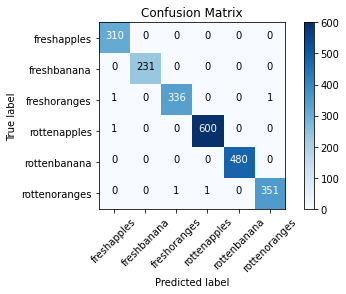

In [27]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig('confusion_matrix_5_100.png')
plt.show()

In [28]:
model.save('model_checkpoint/fruit_classifier_draft_50.h5')